In this notebook we'll train a classifier to find **point behaviors** in inertial sensor data.

In [53]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sktime.classification.compose import TimeSeriesForestClassifier, ColumnEnsembleClassifier
from sktime.utils.data_container import from_3d_numpy_to_nested
from typing import List, Tuple

rg = np.random.Generator(np.random.PCG64(1134))
def flatten(list_of_lists: List[List]) -> List:
    """
    Flatten a list of lists
    
        Parameters: 
            list_of_lists: a nested list
        
        Return:
            A flattened list 
    
    """
    return [i for sublist in list_of_lists for i in sublist]

Generate dummy sensor data and randomly assign events

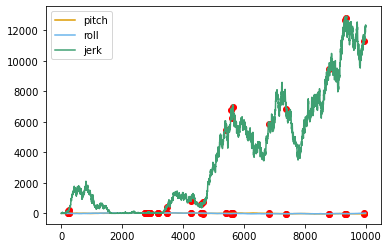

In [32]:
def random_sensor(n):
    return rg.uniform(low=-1., high=1., size=n).cumsum()
N = 10000
sensors = pd.DataFrame(
    {
        "pitch": random_sensor(N),
        "roll": random_sensor(N),
        "jerk": random_sensor(N)**2
    }
)
N_events = 20
events = rg.choice(range(N), size=N_events, replace=False)
events.sort()

# Plot dummy sensor data
sensors.plot.line(y=["pitch", "roll", "jerk"], color=["#DD9A00", "#6AB5EC", "#3FA072"])
for y in ["pitch", "roll", "jerk"]:
    plt.scatter(x=events, y=y, data=sensors.iloc[events], marker="o", color="red")

# How do I make the red points appear over the lines?

Create the training dataset consisting of **all** positive (i.e., the events) and an equal sample size of negatives (randomly selected). We'll use 20 record windows and make sure negative sample windows don't overlap the positives.

In [3]:
# Negatives must be 10 records removed from a positive
win_size = 20
positives = events

def diff_from(xs: np.ndarray, ys: np.ndarray) -> np.ndarray:
    """
    Return the array-wise least difference from another array
    
        Parameters:
            xs: the basis array
            ys: the target array
            
        Returns:
            The minimum absolute difference for each element of xs from the closest value in ys
    """
    return np.array([np.min(np.abs(x - ys)) for x in xs])

# Valid indices for negatives
negative_choices = np.array(range(win_size, len(sensors.index) - win_size - 1, win_size))
diff_from_pos = diff_from(negative_choices, positives)
negative_choices = negative_choices[diff_from_pos > win_size]

# Randomly choose 
negatives = rg.choice(negative_choices, size=len(positives), replace=False)
negatives.sort()

print("+: " + str(positives))
print("-: " + str(negatives))

+: [  87 2097 2370 2457 2822 3133 3854 4158 4471 5212 5508 5964 6141 6172
 6920 7196 7684 7936 8270 9609]
-: [ 320 1060 1420 1840 1920 2420 2560 3420 4400 4740 4900 5040 6640 7060
 7660 7740 8760 8940 9340 9760]


Convert positives and negatives to sktime-compatible format

In [56]:
nested = Tuple[pd.DataFrame, List[str]]
def extract_nested(data: pd.DataFrame, idx: List[int], window_size: int, label: str) -> nested:
    """
    Combine samples and reformat into nested sktime
    
        Parameters:
            data: longitudinal sensor data
            idx: indices of sample centers
            window_size: number of records in each sample window
            label: class label (e.g., "positive" or "negative")
        
        Returns:
            A tuple of sample windows in nested sktime DataFrame format and their labels
    """
    # Create a 3d numpy array of window data
    data_3d = np.empty([len(idx), len(data.columns), window_size], float)
    data_arr = data.to_numpy().transpose()
    start_idx = idx - int(window_size / 2)
    for i, start in enumerate(start_idx):
        data_3d[i] = data_arr[:, start:(start + window_size)]

    # Convert 3d numpy array to nested sktime DataFrame format
    nested = from_3d_numpy_to_nested(data_3d)
    nested.columns = data.columns
    nested.index = idx
    
    return nested, [label] * len(idx)

def concat_nested(nested: List[nested]) -> nested:
    """
    Concatenate multiple sample sets in nested sktime format 
    
        Parameters:
            nested: list of samples in nested sktime format (as returned by extract_nested())
        
        Returns:
            The concatenated nested samples
    """
    return (pd.concat([n[0] for n in nested]), flatten([n[1] for n in nested]))

clf_positives = extract_nested(sensors, positives, win_size, "pos")
clf_negatives = extract_nested(sensors, negatives, win_size, "neg")
clf_data = concat_nested([clf_positives, clf_negatives])
display(clf_data[0].head())
print(clf_data[1][0:5])

,pitch,roll,jerk
87,0 0.455932 1 -0.218355 2 -0.284260 3...,0 -3.402498 1 -4.279768 2 -3.952486 3...,0 31.258315 1 21.458979 2 17.81577...
2097,0 15.612186 1 15.719214 2 16.16845...,0 23.516252 1 22.916414 2 22.18303...,0 37.535682 1 41.048855 2 37.13517...
2370,0 17.653407 1 18.152865 2 17.41987...,0 25.434132 1 24.731373 2 25.36260...,0 95.463710 1 110.278439 2 100.06...
2457,0 25.186732 1 25.432095 2 26.18559...,0 21.356796 1 22.068691 2 22.50499...,0 27.864540 1 20.486574 2 12.46810...
2822,0 15.521597 1 15.887961 2 16.07942...,0 29.308224 1 29.141110 2 29.34109...,0 7.582160 1 10.210550 2 15.91217...


['pos', 'pos', 'pos', 'pos', 'pos']


Fit a ColumnEnsembleClassifier composed of TimeSeriesForest estimators

In [58]:
clf = ColumnEnsembleClassifier(
    estimators=[("TSF_" + c, TimeSeriesForestClassifier(n_estimators=100), [i]) 
                for i, c in enumerate(clf_data[0].columns)]
)
X_train, X_test, y_train, y_test = train_test_split(clf_data[0], clf_data[1], random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5